In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import os, math

### Read in samples

In [2]:
allstar = fits.open('/home/jess/Desktop/Research/data/apogee_data/allStar-l31c.2.fits')

In [3]:
mann = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/mann_87_APOGEE_x_Gaia.csv.gz')
mann['BP_RP'] = mann['phot_bp_mean_mag'] - mann['phot_rp_mean_mag']
mann['J_K'] = mann['J'] - mann['K']
mann['G_ABS'] = mann['phot_g_mean_mag'] + 5*np.log10(mann['parallax'])-10
mann['K_ABS'] = mann['K'] + 5*np.log10(mann['parallax'])-10
mann['DIST'] = 1/np.array(mann['parallax'])

mann_results = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_mann/results/test_results.csv.gz')

In [4]:
west_xm = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/west_x_APOGEE_x_Gaia.csv.gz')
results_w = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_west/results/test_results.csv.gz')
no_spec = list(set(west_xm['APOGEE_ID']) - set(results_w['ID']))
for miss_id in no_spec:
    west_xm = west_xm[west_xm['APOGEE_ID'] != miss_id]
ind_w = np.array([np.where(results_w['ID'] == ID)[0][0] for ID in west_xm['APOGEE_ID']])

spt = west_xm['SpT']
bp_rp_w = west_xm['phot_bp_mean_mag'] - west_xm['phot_rp_mean_mag']
g_abs_w = west_xm['phot_g_mean_mag'] + 5*np.log10(west_xm['parallax'])-10

In [5]:
pms_cat = fits.open('/home/jess/Desktop/Research/data/catalogs/APOGEE_PMS_catalog.fits')
pms_ID = np.array(pms_cat[1].data['2MASS'])

elbadry_cat = pd.read_csv('/home/jess/Desktop/Research/data/catalogs/APOGEE_ElBadry_binaries.csv')
elbadry_ID = elbadry_cat['APOGEE_ID']
skinner_ID = ['2M00372323+4950469','2M03122509+0021585','2M03330508+5101297','2M03393700+4531160',\
              '2M04281703+5521194','2M04373881+4650216','2M04595013+3638144','2M05421216+2224407',\
              '2M05504191+3525569','2M06115599+3325505','2M06125378+2343533','2M06213904+3231006',\
              '2M06561894-0835461','2M07063543+0219287','2M07444028+7946423','2M08100405+3220142',\
              '2M08351992+1408333','2M10331367+3409120','2M10423925+1944404','2M10464238+1626144',\
              '2M10520326+0032383','2M11081979+4751217','2M12045611+1728119','2M12193796+2634445',\
              '2M12214070+2707510','2M12260547+2644385','2M12260848+2439315','2M14545496+4108480',\
              '2M14551346+4128494','2M14562809+1648342','2M15183842-0008235','2M15192613+0153284',\
              '2M15225888+3644292','2M17204248+4205070','2M18514864+1415069','2M19081153+2839105',\
              '2M19235494+3834587','2M19433790+3225124','2M19560585+2205242','2M20474087+3343054',\
              '2M21005978+5103147','2M21234344+4419277','2M21442066+4211363','2M21451241+4225454']
bin_ID = list(set(elbadry_ID) or set(skinner_ID))

In [6]:
test = pd.read_csv('test_results/test_mann_and_west.csv')
test['K_ABS'] = test['K'] + 5*np.log10(test['PLX'])-10
test['J_K'] = test['J'] - test['K']
full = test
test['ID'] = test['APOGEE_ID']

### Remove known binaries and pre-MS stars

In [7]:
sel = test
for ID in pms_ID: #list(set(bin_ID) or set(pms_ID)):
    sel = sel[sel['ID'] != ID]
for ID in bin_ID: #list(set(bin_ID) or set(pms_ID)):
    sel = sel[sel['ID'] != ID]
    
print(len(test) - len(sel))
    
# cuts = test.set_index('ID').subtract(sel.set_index('ID'), fill_value=0)

333


In [8]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# ax1.scatter(sel['BP_RP'], sel['G_ABS'], c=sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(sel)))
# ax1.scatter(cuts['BP_RP'], cuts['G_ABS'], c='r', edgecolor='none', s=10, marker='s', \
#                  label='PMS: %s sources'%(len(test) - len(sel)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.5)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = ax2.scatter(sel['J_K'], sel['K_ABS'], c=sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(sel)))
# ax2.scatter(cuts['J_K'], cuts['K_ABS'], c='r', edgecolor='none', s=10, marker='s', \
#                  label='PMS: %s sources'%(len(test) - len(sel)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [9]:
test = sel

### Chi^2 selection

In [10]:
chi_cut = 100000

In [11]:
## Before plots

# plt.hist(test['CHI'], histtype='step')
# plt.axvline(x=chi_cut, color='k')
# plt.yscale('log')
# plt.xlabel(r'$\chi^2$')
# plt.show()

# #=====

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])
# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.5)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [12]:
test = test[test['CHI_MANN'] < chi_cut]

In [13]:
# plt.hist(test['CHI'], histtype='step')
# plt.xlabel(r'$\chi^2$')
# plt.show()

# #=====

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])
# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.5)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [14]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# polygon = plt.Polygon(p, fill=False, color='r', linewidth=2)
# ax1.add_patch(polygon)
# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.4)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# rect = plt.Rectangle((jk_cut[0], Mk_cut[0]), w, h, fill=False, color='r', linewidth=2)
# ax2.add_patch(rect)
# pl = ax2.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(12,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1, fontsize=13)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# cb.set_label(r'Cannon Model $\chi^2$ fit', fontsize=15)
# plt.show()

### RA and DEC selection

In [15]:
orion_coord = []
taurus_coord = []
radius_cut = 5

In [16]:
# pl = plt.scatter(test['RA'], test['DEC'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none')
# plt.xlabel(r'$\alpha$', fontsize=15)
# plt.ylabel(r'$\delta$', fontsize=15)
# cb = plt.colorbar(pl)
# cb.set_label(r'Cannon Model $\chi^2$ fit', fontsize=15)
# plt.minorticks_on()
# plt.show()

# #=====

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])
# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.5)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

### J, K cmd selection

In [17]:
jk_cut = [.7, 1.1]
Mk_cut = [4.3, 9]

w, h = jk_cut[1] - jk_cut[0], Mk_cut[1] - Mk_cut[0]

jk_sel = test[test['J_K'] > jk_cut[0]][test['J_K'] < jk_cut[1]][test['K_ABS'] > Mk_cut[0]][test['K_ABS'] < Mk_cut[1]]
# jk_rem = test.set_index('ID').subtract(jk_sel.set_index('ID'), fill_value=0)

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [18]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# ax1.scatter(jk_sel['BP_RP'], jk_sel['G_ABS'], c=jk_sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Select: %s sources'%(len(jk_sel)))
# ax1.scatter(jk_rem['BP_RP'], jk_rem['G_ABS'], color='r', edgecolor='none', s=10, marker='s', \
#                  label='Cut: %s sources'%(str(len(test) - len(jk_sel))))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(17,7.5)
# ax1.set_xlim(1,6)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# rect = plt.Rectangle((jk_cut[0], Mk_cut[0]), w, h, fill=False, color='r', linewidth=2)
# ax2.add_patch(rect)
# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,2)
# ax2.set_xlim(.3,3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [19]:
test = jk_sel

In [20]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(16,7.5)
# ax1.set_xlim(1,5)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,3.6)
# ax2.set_xlim(.65,1.3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

### BP, RP cmd selection

In [21]:
p = [[1.4, 7.5], [2.2, 7.5], [4.2, 14], [3.3, 14]]
slope = [(p[3][1] - p[0][1])/(p[3][0] - p[0][0]), (p[2][1] - p[1][1])/(p[2][0] - p[1][0])]
inter = [p[0][1] - slope[0]*p[0][0], p[1][1] - slope[1]*p[1][0]]

test['line1'] = test['BP_RP']*slope[0] + inter[0]
test['line2'] = test['BP_RP']*slope[1] + inter[1]

line_sel = test.query('G_ABS < line1').query('G_ABS > line2')
# line_rem = test.set_index('ID').subtract(line_sel.set_index('ID'), fill_value=0)

In [22]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# polygon = plt.Polygon(p, fill=False, color='r', linewidth=2)
# ax1.add_patch(polygon)
# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(line_sel)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(16,7)
# ax1.set_xlim(1,5)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = ax2.scatter(line_sel['J_K'], line_sel['K_ABS'], c=line_sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(line_sel)))
# ax2.scatter(line_rem['J_K'], line_rem['K_ABS'], color='r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)-len(line_sel)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,3.6)
# ax2.set_xlim(.65,1.3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [23]:
test = line_sel

In [24]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# ax1.scatter(test['BP_RP'], test['G_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(15,7.5)
# ax1.set_xlim(1.5,4.2)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = plt.scatter(test['J_K'], test['K_ABS'], c=test['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,3.6)
# ax2.set_xlim(.65,1.3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

### Cut sources with Teff and [Fe/H] outside the training sample range

In [25]:
teff_rng = [2850, 4150] # [2859.0, 4131.0] 
fe_h_rng = [-0.5, 0.5] # [-0.48, 0.49]

train_sel = test[test['TEFF'] > teff_rng[0]][test['TEFF'] < teff_rng[1]][test['FE_H'] > fe_h_rng[0]][test['FE_H'] < fe_h_rng[1]]
# train_cut = test.set_index('ID').subtract(train_sel.set_index('ID'), fill_value=0)

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [26]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[16,5])

# ax1.scatter(train_sel['BP_RP'], train_sel['G_ABS'], c=train_sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(train_sel)))
# ax1.scatter(train_cut['BP_RP'], train_cut['G_ABS'], c='r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(test)-len(train_sel)))
# ax1.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax1.set_xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
# ax1.set_ylabel(r'$M_{G}$', fontsize=15)
# ax1.set_ylim(15,7.5)
# ax1.set_xlim(1.5,4.2)
# ax1.legend(loc='lower left', scatterpoints=1)
# ax1.minorticks_on()

# pl = ax2.scatter(train_sel['J_K'], train_sel['K_ABS'], c=train_sel['CHI'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(train_sel)))
# ax2.scatter(train_cut['J_K'], train_cut['K_ABS'], c='r', edgecolor='none', s=10, marker='s', \
#                  label='Test: %s sources'%(len(train_cut)))
# ax2.scatter(mann['J_K'], mann['K_ABS'], color='orange', marker='^', label='Training sample', s=25)
# ax2.set_xlabel(r'$J-K$', fontsize=15)
# ax2.set_ylabel(r'$M_{k}$', fontsize=15)
# ax2.set_ylim(11,3.6)
# ax2.set_xlim(.65,1.3)
# ax2.legend(loc='lower right', scatterpoints=1)
# ax2.minorticks_on()

# cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
# plt.show()

In [27]:
test = train_sel

### Final selection plots

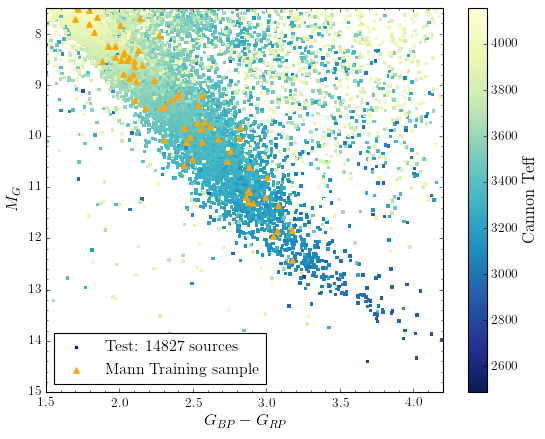

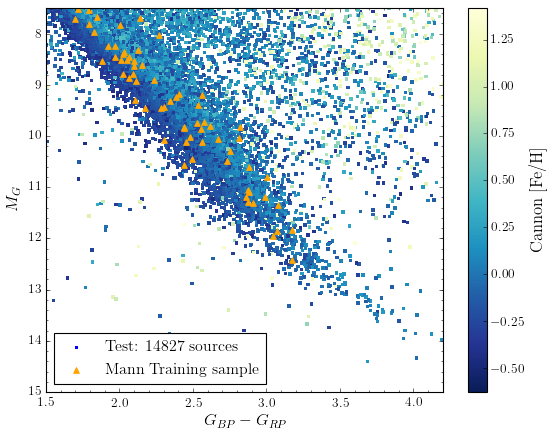

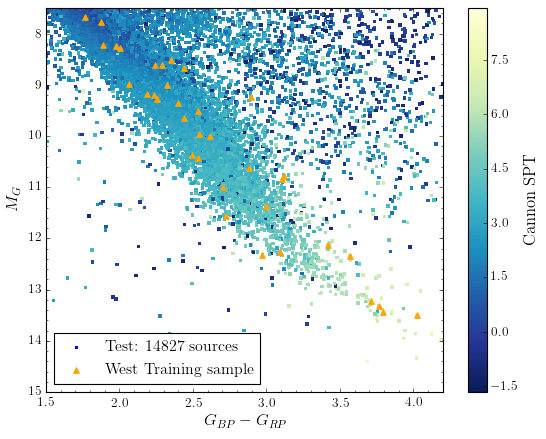

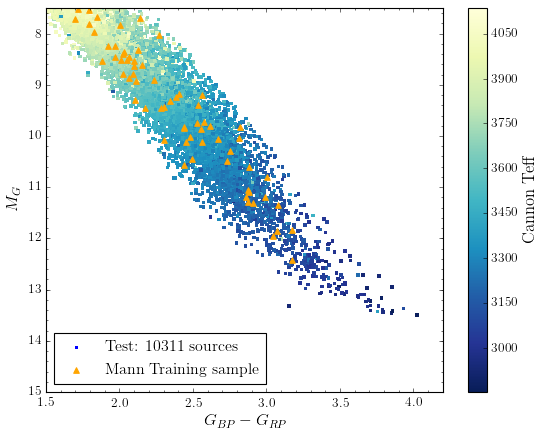

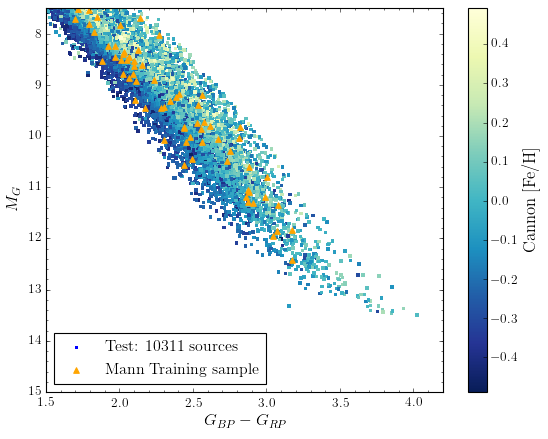

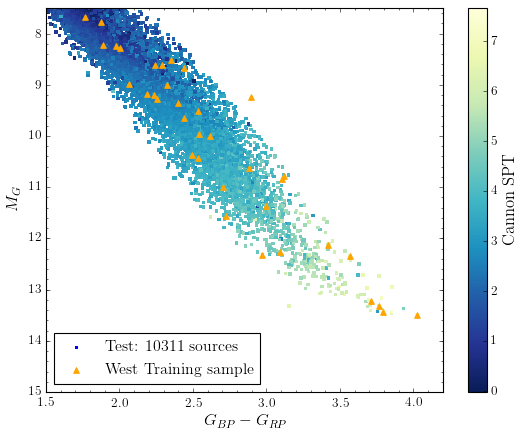

In [28]:
pl = plt.scatter(full['BP_RP'], full['G_ABS'], c=full['TEFF'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(full)))
plt.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon Teff', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

pl = plt.scatter(full['BP_RP'], full['G_ABS'], c=full['FE_H'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(full)))
plt.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon [Fe/H]', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

pl = plt.scatter(full['BP_RP'], full['G_ABS'], c=full['SPT'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(full)))
plt.scatter(bp_rp_w, g_abs_w, color='orange', marker='^', label='West Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon SPT', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

#=============


pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['TEFF'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(test)))
plt.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon Teff', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['FE_H'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(test)))
plt.scatter(mann['BP_RP'], mann['G_ABS'], color='orange', marker='^', label='Mann Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon [Fe/H]', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['SPT'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(test)))
plt.scatter(bp_rp_w, g_abs_w, color='orange', marker='^', label='West Training sample', s=25)
plt.colorbar(pl, orientation='vertical').set_label(r'Cannon SPT', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.show()

In [147]:
# test = test.drop(['line1', 'line2', 'Unnamed: 0'], axis=1)
test = test.drop(['J_K', 'K_ABS'], axis=1)
test.to_csv('test_results/safe_sample_results.csv', index=False)
len(test)

10311

In [146]:
set(test.keys()) - set(['BP_RP', 'CHI_MANN', 'DEC', 'DIST', 'FE_H', 'GAIA_ID', 'G_ABS', 'H',
       'J', 'K', 'PLX', 'PLX_ERR', 'PMDEC', 'PMDEC_ERR', 'PMRA', 'PMRA_ERR',
       'RA', 'RV_GAIA', 'RV_GAIA_ERR', 'TEFF', 'X', 'Y', 'Z', 'SPT',
       'CHI_WEST', 'ID', 'BP_MAG', 'G_MAG', 'H_ERR', 'J_ERR', 'K_ERR',
       'RP_MAG', 'RV_APOGEE', 'RV_APOGEE_ERR', 'Vx', 'Vy', 'Vz'])

{'APOGEE_ID', 'J_K', 'K_ABS'}

### Validation by color-temperature relations & comparison to ASPCAP

In [37]:
# Load APASS DR9 cross match
apass = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/apogee_test/test_results/test_mann_x_APASS.csv')
apass = pd.DataFrame(data={'ID':apass['ID'], 'Vmag':apass['Vmag']})
apass_match = pd.merge(apass, test, on='ID')
len(apass_match['ID'])

6257

In [38]:
# Get ASPCAP measurements for the cross match
AP_ID = np.array(allstar[1].data['APOGEE_ID'], dtype=str)
id_ind = np.array([np.where(AP_ID == ID)[0][0] for ID in apass_match['ID']])
print(len(AP_ID), len(id_ind), len(apass_match['ID']))

AP_FPARAM = np.array(allstar[1].data['FPARAM'])[id_ind]
apass_match['AP_TEFF'] = AP_FPARAM.T[0]
apass_match['AP_FE_H'] = AP_FPARAM.T[3]

apass_match['AP_TEFF'][apass_match['AP_TEFF'] < 0] = np.nan
apass_match['AP_FE_H'][apass_match['AP_FE_H'] < -10] = np.nan

277371 6257 6257


/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [39]:
apass_match.keys()

Index(['ID', 'Vmag', 'BP_RP', 'CHI_MANN', 'DEC', 'DIST', 'FE_H', 'GAIA_ID',
       'G_ABS', 'H', 'J', 'K', 'PLX', 'PLX_ERR', 'PMDEC', 'PMDEC_ERR', 'PMRA',
       'PMRA_ERR', 'RA', 'RV_GAIA', 'RV_GAIA_ERR', 'TEFF', 'X', 'Y', 'Z',
       'SPT', 'CHI_WEST', 'BP_MAG', 'G_MAG', 'H_ERR', 'J_ERR', 'K_ERR',
       'RP_MAG', 'RV_APOGEE', 'RV_APOGEE_ERR', 'Vx', 'Vy', 'Vz', 'APOGEE_ID',
       'K_ABS', 'J_K', 'line1', 'line2', 'AP_TEFF', 'AP_FE_H'],
      dtype='object')

In [44]:
v_j = np.array(apass_match['Vmag'] - apass_match['J'])
v_k = np.array(apass_match['Vmag'] - apass_match['K'])

# Mann relations
vj_teff = 3500*(2.515 - 1.054*v_j + 0.2965*(v_j)**2 - 0.04150*(v_j)**3 + 0.002245*(v_j)**4 + 0.05262*apass_match['FE_H'])
vj_diff = apass_match['TEFF'] - vj_teff

vj_teff_ap = 3500*(2.515 - 1.054*v_j + 0.2965*(v_j)**2 - 0.04150*(v_j)**3 + 0.002245*(v_j)**4 + 0.05262*apass_match['AP_FE_H'])
vj_diff_ap = apass_match['AP_TEFF'] - vj_teff_ap

# Casagrande relation
vk_teff = 5040/(-0.4809 + 0.8009*v_k - 0.1039*(v_k)**2 + 0.0056*(v_k)**3)
vk_diff = apass_match['TEFF'] - vk_teff
vk_diff_ap = apass_match['AP_TEFF'] - vk_teff

# Boyajian relation
# vk_teff2 = 8984 - 2914*v_k + 588*(v_k)**2 - 47.4*(v_k)**3
vk_teff2 = 7643 - 1523*(v_k) + 134*(v_k)**2 + 137*(v_k)*apass_match['FE_H'] - 202*apass_match['FE_H'] + 157*(apass_match['FE_H'])**2
vk_diff2 = apass_match['TEFF'] - vk_teff2

vk_teff_ap2 = 7643 - 1523*(v_k) + 134*(v_k)**2 + 137*(v_k)*apass_match['AP_FE_H'] - 202*apass_match['AP_FE_H'] + 157*(apass_match['FE_H'])**2
vk_diff_ap2 = apass_match['AP_TEFF'] - vk_teff_ap2

x = np.linspace(2000,5000)

In [59]:
print(min(apass_match['TEFF']), max(apass_match['TEFF']))
print(min(apass_match['AP_TEFF']), max(apass_match['AP_TEFF']))

len(np.where(apass_match['AP_TEFF'] > 4200)[0])

2979.5631769413058 4134.607104534338
2500.6 7997.1


509

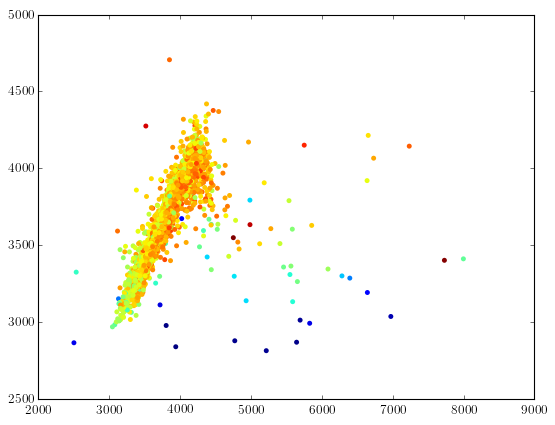

In [52]:
plt.scatter(apass_match['AP_TEFF'], vj_teff_ap, edgecolor='none', c=apass_match['AP_FE_H'])
plt.show()
plt.scatter(apass_match['AP_TEFF'], vj_teff_ap, edgecolor='none', c=apass_match['AP_FE_H'])
plt.show()
plt.scatter(apass_match['AP_TEFF'], vj_teff_ap, edgecolor='none', c=apass_match['AP_FE_H'])
plt.show()

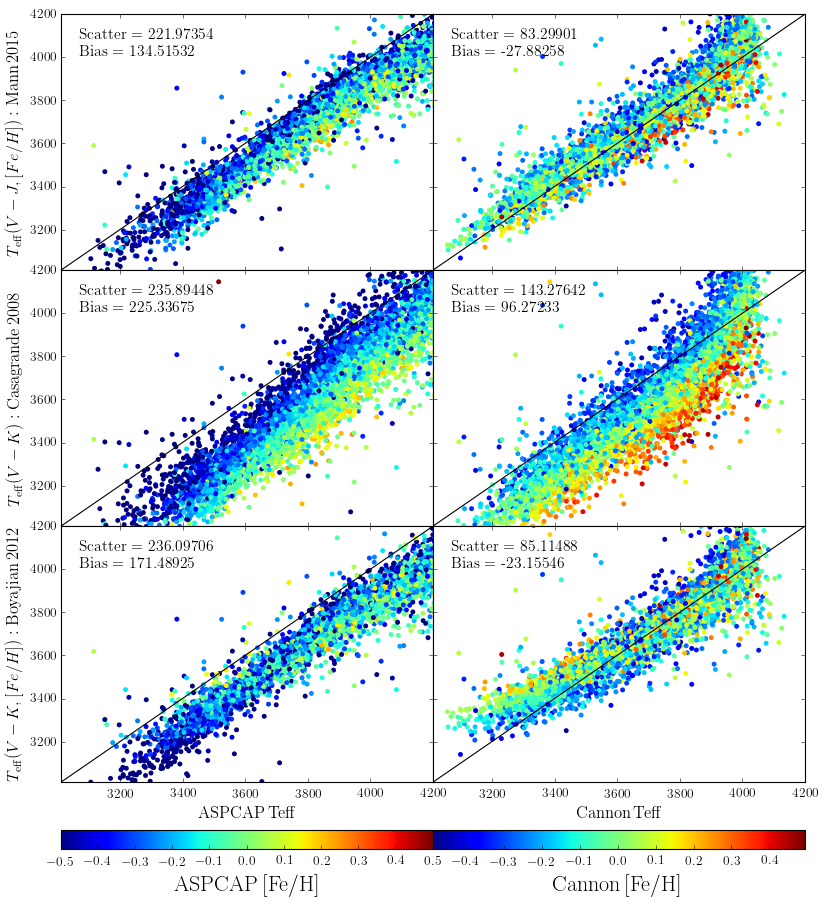

In [64]:
text1 = 'Scatter = %s \nBias = %s'%(round(np.std(vj_diff_ap),5), round(np.mean(vj_diff_ap),5))
text2 = 'Scatter = %s \nBias = %s'%(round(np.std(vj_diff),5), round(np.mean(vj_diff),5))
text3 = 'Scatter = %s \nBias = %s'%(round(np.std(vk_diff_ap),5), round(np.mean(vk_diff_ap),5))
text4 = 'Scatter = %s \nBias = %s'%(round(np.std(vk_diff),5), round(np.mean(vk_diff),5))
text5 = 'Scatter = %s \nBias = %s'%(round(np.std(vk_diff_ap2),5), round(np.mean(vk_diff_ap2),5))
text6 = 'Scatter = %s \nBias = %s'%(round(np.std(vk_diff2),5), round(np.mean(vk_diff2),5))

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=[12,15], sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

ax1.plot(x,x, color='k')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
im1 = ax1.scatter(apass_match['AP_TEFF'], vj_teff_ap, edgecolor='none', c=np.clip(apass_match['AP_FE_H'],-.5,.5))
ax1.set_xlim(3010,4200)
ax1.set_ylim(3010,4200)
ax1.set_ylabel(r'$T_{\rm eff}(V-J, [Fe/H]): {\rm Mann \, 2015}$', fontsize=15)

ax2.plot(x,x, color='k')
ax2.text(0.05, 0.95, text2, fontsize=14, transform=ax2.transAxes, verticalalignment='top')
im2 = ax2.scatter(apass_match['TEFF'], vj_teff, edgecolor='none', c=apass_match['FE_H'])

#===========
ax3.plot(x,x, color='k')
ax3.text(0.05, 0.95, text3, fontsize=14, transform=ax3.transAxes, verticalalignment='top')
ax3.scatter(apass_match['AP_TEFF'], vk_teff, edgecolor='none', c=np.clip(apass_match['AP_FE_H'],-.5,.5))
ax3.set_ylabel(r'$T_{\rm eff}(V-K): {\rm Casagrande \, 2008}$', fontsize=15)

ax4.plot(x,x, color='k')
ax4.text(0.05, 0.95, text4, fontsize=14, transform=ax4.transAxes, verticalalignment='top')
ax4.scatter(apass_match['TEFF'], vk_teff, edgecolor='none', c=apass_match['FE_H'])

#===========
ax5.plot(x,x, color='k')
ax5.text(0.05, 0.95, text5, fontsize=14, transform=ax5.transAxes, verticalalignment='top')
ax5.scatter(apass_match['AP_TEFF'], vk_teff_ap2, edgecolor='none', c=np.clip(apass_match['AP_FE_H'],-.5,.5))
ax5.set_ylabel(r'$T_{\rm eff}(V-K, [Fe/H]): {\rm Boyajian \, 2012}$', fontsize=15)

ax6.plot(x,x, color='k')
ax6.text(0.05, 0.95, text6, fontsize=14, transform=ax6.transAxes, verticalalignment='top')
ax6.scatter(apass_match['TEFF'], vk_teff2, edgecolor='none', c=apass_match['FE_H'])

ax5.set_xlabel(r'$\rm ASPCAP \, Teff$', fontsize=15)
ax6.set_xlabel(r'$\rm Cannon \, Teff$', fontsize=15)

#===========
# plt.tight_layout()
cb1 = fig.colorbar(im1, ax=(ax1, ax3, ax5), orientation='horizontal', pad=.05)
cb1.set_label(r'${\rm ASPCAP \, [Fe/H]}$', fontsize=20)

cb2 = fig.colorbar(im2, ax=(ax2, ax4, ax6), orientation='horizontal', pad=.05)
cb2.set_label(r'${\rm Cannon \, [Fe/H]}$', fontsize=20)
plt.savefig('../../paper/figures/aspcap_cannon_validation.png')
plt.show()

In [61]:
# Get ASPCAP measurements for the cross match
AP_ID = np.array(allstar[1].data['APOGEE_ID'], dtype=str)
id_ind = np.array([np.where(AP_ID == ID)[0][0] for ID in test['ID']])
print(len(AP_ID), len(id_ind), len(test['ID']))

AP_FPARAM = np.array(allstar[1].data['FPARAM'])[id_ind]
test['AP_TEFF'] = AP_FPARAM.T[0]
test['AP_FE_H'] = AP_FPARAM.T[3]

test['AP_TEFF'][test['AP_TEFF'] < 0] = np.nan
test['AP_FE_H'][test['AP_FE_H'] < -10] = np.nan

277371 10311 10311


/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


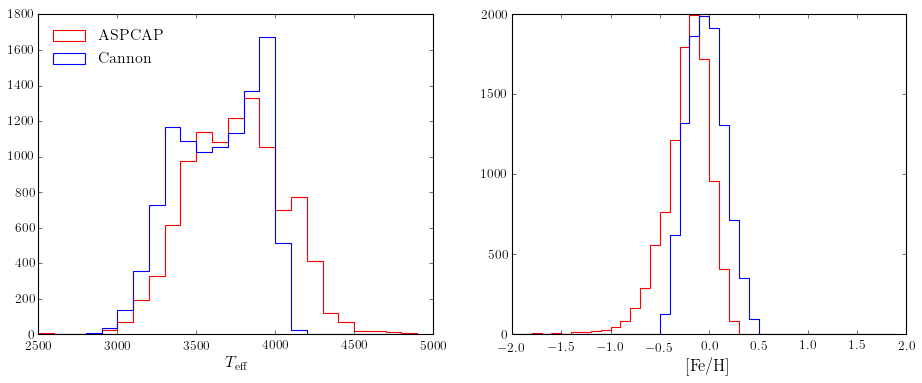

(10258, 10311)

In [62]:
bin1 = np.arange(2500, 5000, 100)
bin2 = np.arange(-2, 2, .1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[14,5])

ax1.hist(test['AP_TEFF'][~np.isnan(test['AP_TEFF'])], bins=bin1, histtype='step', color='r', label='ASPCAP')
ax1.hist(test['TEFF'], bins=bin1, histtype='step', color='b', label='Cannon')
ax1.set_xlabel(r'$T_{\rm eff}$', fontsize=15)

ax2.hist(test['AP_FE_H'][~np.isnan(test['AP_FE_H'])], bins=bin2, histtype='step', color='r', label='ASPCAP')
ax2.hist(test['FE_H'], bins=bin2, histtype='step', color='b', label='Cannon')
ax2.set_xlabel(r'[Fe/H]', fontsize=15)

ax1.legend(loc='upper left', frameon=False)
plt.show()

len(test['AP_TEFF'][~np.isnan(test['AP_TEFF'])]), len(test)